# Project 3: Web APIs & NLP

## Problem Statement

Many times, advertisers want to target their marketing to customers that will purchase their product. That is why, if someone is selling a book, they would be interested in showing a book ad to someone who is already talking about books. The data science problem answered in this project is whether or not subreddit titles and self text are predictive of the subreddit "movies" and "books" topics. To approach this problem, I leveraged the Pushshift API and NLP to train binary classifiers.

## Executive Summary

Both the Logistic Regression and Multinomial Naive Bayes models provided good outputs. Though the model shows high variance, as can be seen from the higher train than test score, the model is able to predict whether a document is coming from a Movies subreddit or a Books subreddit with good accuracy. Limiting the number of features or adding regulation would reduce variance, but also decrease the accuracy of the model.

## Contents

- [Data Gathering](#Data-Gathering)
- [EDA](#EDA)
- [Models](#Models)
- [Results](#Results)
- [Conclusion](#Conclusion)

# Data Gathering

Import libraries

In [238]:
import pandas as pd
import datetime as dt
import time
import requests
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

Using Pushshift API, The pushshift.io Reddit API was designed to help provide enhanced functionality and search capabilities for searching Reddit comments and submissions

In [241]:

def query_pushshift(subreddit, kind = 'submission', day_window = 7, n = 5):
    SUBFIELDS = ['title', 'selftext', 'subreddit', 'created_utc', 'author', 'num_comments', 'score', 'is_self']
    
    # BASE_URL & Parameters
    BASE_URL = f"https://api.pushshift.io/reddit/search/{kind}" # also known as the "API endpoint" 
    size = 500
      
    # instantiate empty list for temp storage
    posts = []
    
    # implement for loop with `time.sleep(2)`
    for i in range(1, n + 1):
        response = requests.get(BASE_URL,
                                params = {
                                    'subreddit': subreddit,
                                    'size': size,
                                    'after': f'{day_window*i}d'
                                })
        print(f'Getting data from subreddit {subreddit} after {day_window*i} days')
        assert response.status_code == 200, 'Check url'
        json = response.json()['data']
        df = pd.DataFrame.from_dict(json)
        posts.append(df)
        time.sleep(2)
    
    # pd.concat storage list
    full = pd.concat(posts, sort=False)
    
    # if submission
    if kind == "submission":
        # select desired columns
        full = full[SUBFIELDS]
        # drop duplicates
        full.drop_duplicates(inplace = True)
        # select `is_self` == True
        full = full.loc[full['is_self'] == True]

    # create `timestamp` column
    full['timestamp'] = full["created_utc"].map(dt.date.fromtimestamp)
    
    print("Query Complete!")    
    return full 

Getting results for movies and books

In [247]:
results_movies = query_pushshift("movies")

Getting data from subreddit movies after 7 days
Getting data from subreddit movies after 14 days
Getting data from subreddit movies after 21 days
Getting data from subreddit movies after 28 days
Getting data from subreddit movies after 35 days
Query Complete!


In [243]:
results_books = query_pushshift("books")

Getting data from subreddit books after 7 days
Getting data from subreddit books after 14 days
Getting data from subreddit books after 21 days
Getting data from subreddit books after 28 days
Getting data from subreddit books after 35 days
Query Complete!


# EDA

Checking data shape, null values, graphing, and more!

In [248]:
# movie shape
movies = results_movies.shape
movies

(936, 9)

In [249]:
# books shape
books = results_books.shape
books

(2041, 9)

In [250]:
# null values in movies data
results_movies['selftext'].isnull().sum()/movies[0]

0.03311965811965812

In [251]:
# null values in books data
results_books['selftext'].isnull().sum()/books[0]

0.057814796668299855

In [252]:
# remove null values
results_movies = results_movies[results_movies['selftext'].notnull()]
results_books = results_books[results_books['selftext'].notnull()]

In [253]:
# new movie shape
results_movies.shape

(905, 9)

In [254]:
# new movie shape
results_books.shape

(1923, 9)

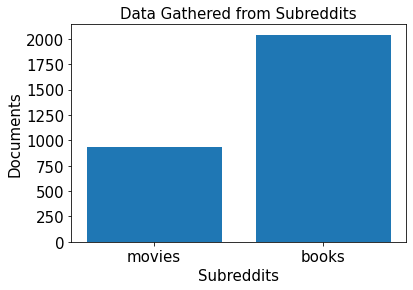

In [255]:
# plot number of documents for each category
plt.bar(['movies', 'books'], [movies[0], books[0]])
plt.xlabel("Subreddits", fontsize= 15)
plt.ylabel("Documents", fontsize= 15)
plt.title("Data Gathered from Subreddits", fontsize=15)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15);

In [440]:
# scaling down data to have a balanced dataset
results_books_scaled = results_books.copy().sample(frac = 0.48)
results_books_scaled.shape

(923, 9)

In [441]:
# concatenating data from Movies and Books
frames = [results_movies, results_books_scaled]
df = pd.concat(frames)

In [377]:
# reset index
df.reset_index(drop = True, inplace = True) 

In [378]:
# checking value counts
df['subreddit'].value_counts()

books     923
movies    905
Name: subreddit, dtype: int64

In [379]:
# checking baseline model
df['subreddit'].value_counts(normalize = True)

books     0.504923
movies    0.495077
Name: subreddit, dtype: float64

In [380]:
# changing subreddit so that books = 1 and movies = 0
df['subreddit'] = df['subreddit'].map({'books': 1, 'movies': 0})

In [381]:
# checking counts didn't change
df['subreddit'].value_counts()

1    923
0    905
Name: subreddit, dtype: int64

In [313]:
# displaying data, notice both title and selftext contain text
df.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Someone know the movie?,[removed],0,1586513050,snwcre,0,1,True,2020-04-10
1,Have you read any disturbing book(s) that the ...,[removed],1,1585943429,vecinadeblog,2,1,True,2020-04-03
2,Do You Toss Book-Covers?,[removed],1,1586021945,ShockwaveSkywarp,1,1,True,2020-04-04
3,Staircase remodel with book titles,[removed],1,1584825797,swest211,3,2,True,2020-03-21
4,Which book was the very definition of a page-t...,[removed],1,1587096529,willowander,1,1,True,2020-04-16


In [302]:
# this function will help visualize the top words with highest frequency
def top_words(corpus, ngram, stop_w):

   # https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
    vect = CountVectorizer (ngram_range = ngram , stop_words = stop_w)
    vec = vect.fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [[word, sum_words[0, idx]] for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    words = [word for word, count in words_freq]
    count = [count for word, count in words_freq]
    
    plt.figure(figsize=(9, 9))
    plt.barh(words[:20], count[:20])
    plt.xlabel("Frequency", fontsize= 15)
    plt.ylabel("Word", fontsize= 15)
    plt.title("Word Frequency", fontsize=25)
    plt.xticks(fontsize= 15)
    plt.yticks(fontsize= 15);

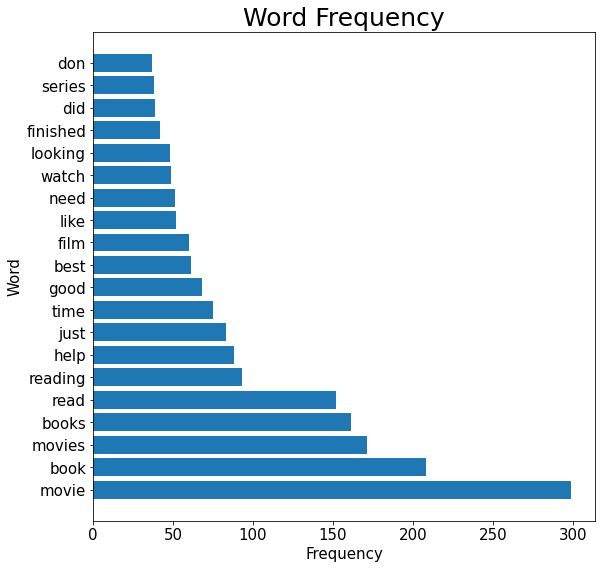

In [305]:
# looking at the "title" feature
top_words(df['title'], ngram = (1,2), stop_w = 'english')

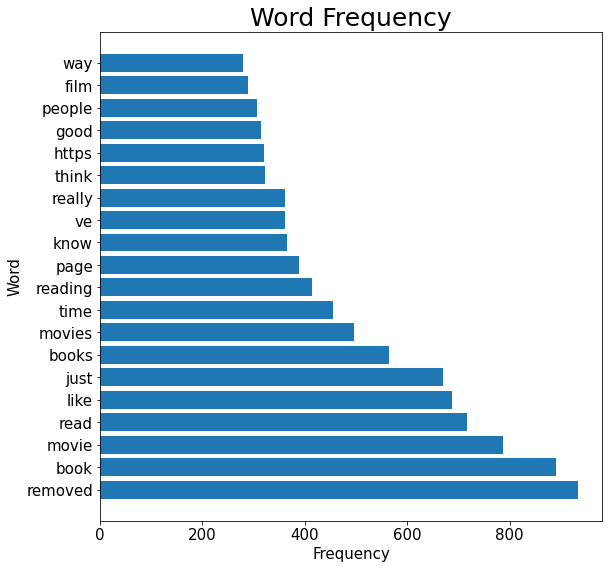

In [307]:
# Concatenating the "title" column with the "selftext" column
top_words(df['title'] + " " + df['selftext'], ngram = (1,2), stop_w = 'english')

# Models

The models I chose are Logistic Regression, Multinomial Naive Bayes, and also checked a Decision Tree Classifier

In [404]:
# I will use the concatenated column that includes both the text in the title column as well as the self text column
X = df['title'] + " " + df['selftext']
y = df['subreddit']
# X = df['title'] was not used since it provided lower scores

# Split into train/test 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)


Logistic Regression

In [354]:
def grid_search_reddit_lr(X_train, X_test, y_train, y_test, vectorizer = TfidfVectorizer(), ngram = [(1,1), (2,2), (1,2)],
                       stop_w = ['english'], penalty = ['none', 'l2'], c = [0.2,0.5, 1,2,3], m_iter = [1000], max_d = [1.0], min_d = [1], max_f = [None], accents = [None]):
    
    # Define Pipeline - Remeber the step structure (list of tuple)
    pipe = Pipeline(steps = [('vectorizer', vectorizer),
                             ('model', LogisticRegression())
                              ])

    # Construct Grid Parameters
    hyperparams = {'vectorizer__ngram_range': ngram,
                   'vectorizer__stop_words': stop_w,
                   'vectorizer__max_df': max_d,
                   'vectorizer__min_df': min_d,
                   'vectorizer__max_features': max_f,
                   'vectorizer__strip_accents': accents,
                   'model__penalty': penalty,
                   'model__C': c,
                   'model__max_iter': m_iter
                  }

    # Perform Grid Search
    lr = GridSearchCV(pipe,
                     param_grid = hyperparams,
                     cv = 3,
                     scoring = 'accuracy')

    results = lr.fit(X_train, y_train)
    
    # Get score
    train_score = results.best_score_
    print('Best crossval score: {:.4f}'.format(train_score))
    train_score = results.score(X_train, y_train)
    print('Best TRAIN score: {:.4f}'.format(train_score))
    test_score = results.score(X_test, y_test)
    print('Best TEST score: {:.4f}'.format(test_score))
    print(results.best_params_)

    
    return lr

Multinomial Naive Bayes

In [429]:
def grid_search_reddit_nb(X_train, X_test, y_train, y_test, vectorizer = TfidfVectorizer(), ngram = [(1,1), (2,2), (1,2)],
                       stop_words = [None, 'english'], max_f = [None], min_d= [1], max_d=[.98, .99, .97, 1, 1.0]):
    
    # Define Pipeline - Remeber the step structure (list of tuple)
    pipe = Pipeline(steps = [('vectorizer', vectorizer),
                             ('model', MultinomialNB())
                              ])

    # Construct Grid Parameters
    hyperparams = {'vectorizer__ngram_range': ngram,
                   'vectorizer__stop_words': stop_words,
                   'vectorizer__max_features': max_f,
                   'vectorizer__min_df': min_d,
                   'vectorizer__max_df': max_d
                  }

    # Perform Grid Search
    nb = GridSearchCV(pipe,
                     param_grid = hyperparams,
                     cv = 3,
                     scoring = 'accuracy')

    results = nb.fit(X_train, y_train)
                             
    # Get score
    train_score = results.best_score_
    print('Best crossval score: {:.4f}'.format(train_score))
    train_score = results.score(X_train, y_train)
    print('Best TRAIN score: {:.4f}'.format(train_score))
    test_score = results.score(X_test, y_test)
    print('Best TEST score: {:.4f}'.format(test_score))
    print(results.best_params_)
    
    return nb


Decision Tree Classifier

In [54]:
def grid_search_reddit_tree(X_train, X_test, y_train, y_test, vectorizer = TfidfVectorizer(), ngram = [(1,1), (2,2), (1,2)],
                       stop_w = ['english'], penalty = ['none', 'l2'], C = [1, 3, 10, 1000], m_iter = [1000]):
    
    # Define Pipeline - Remeber the step structure (list of tuple)
    pipe = Pipeline(steps = [('vectorizer', vectorizer),
                             ('model', DecisionTreeClassifier())
                              ])

    # Construct Grid Parameters
    hyperparams = {'vectorizer__ngram_range': ngram,
                   'vectorizer__stop_words': stop_w, 
                  }

    # Perform Grid Search
    lr = GridSearchCV(pipe,
                     param_grid = hyperparams,
                     cv = 3,
                     scoring = 'accuracy')

    results = lr.fit(X_train, y_train)
                             
    # Get score
    train_score = results.best_score_
    print('Best crossval score: {:.4f}'.format(train_score))
    train_score = results.score(X_train, y_train)
    print('Best TRAIN score: {:.4f}'.format(train_score))
    test_score = results.score(X_test, y_test)
    print('Best TEST score: {:.4f}'.format(test_score))
    print(results.best_params_)

    
    return lr

# Results

In [398]:
# created a list of words where I added different words to the 'english' stopwords to check performance
list_of_words = ['removed',
                 'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides',
           'between',
           'beyond',
           'bill',
           'both',
           'bottom',
           'but',
           'by',
           'call',
           'can',
           'cannot',
           'cant',
           'co',
           'con',
           'could',
           'couldnt',
           'cry',
           'de',
           'describe',
           'detail',
           'do',
           'done',
           'down',
           'due',
           'during',
           'each',
           'eg',
           'eight',
           'either',
           'eleven',
           'else',
           'elsewhere',
           'empty',
           'enough',
           'etc',
           'even',
           'ever',
           'every',
           'everyone',
           'everything',
           'everywhere',
           'except',
           'few',
           'fifteen',
           'fifty',
           'fill',
           'find',
           'fire',
           'first',
           'five',
           'for',
           'former',
           'formerly',
           'forty',
           'found',
           'four',
           'from',
           'front',
           'full',
           'further',
           'get',
           'give',
           'go',
           'had',
           'has',
           'hasnt',
           'have',
           'he',
           'hence',
           'her',
           'here',
           'hereafter',
           'hereby',
           'herein',
           'hereupon',
           'hers',
           'herself',
           'him',
           'himself',
           'his',
           'how',
           'however',
           'hundred',
           'i',
           'ie',
           'if',
           'in',
           'inc',
           'indeed',
           'interest',
           'into',
           'is',
           'it',
           'its',
           'itself',
           'keep',
           'last',
           'latter',
           'latterly',
           'least',
           'less',
           'ltd',
           'made',
           'many',
           'may',
           'me',
           'meanwhile',
           'might',
           'mill',
           'mine',
           'more',
           'moreover',
           'most',
           'mostly',
           'move',
           'much',
           'must',
           'my',
           'myself',
           'name',
           'namely',
           'neither',
           'never',
           'nevertheless',
           'next',
           'nine',
           'no',
           'nobody',
           'none',
           'noone',
           'nor',
           'not',
           'nothing',
           'now',
           'nowhere',
           'of',
           'off',
           'often',
           'on',
           'once',
           'one',
           'only',
           'onto',
           'or',
           'other',
           'others',
           'otherwise',
           'our',
           'ours',
           'ourselves',
           'out',
           'over',
           'own',
           'part',
           'per',
           'perhaps',
           'please',
           'put',
           'rather',
           're',
           'same',
           'see',
           'seem',
           'seemed',
           'seeming',
           'seems',
           'serious',
           'several',
           'she',
           'should',
           'show',
           'side',
           'since',
           'sincere',
           'six',
           'sixty',
           'so',
           'some',
           'somehow',
           'someone',
           'something',
           'sometime',
           'sometimes',
           'somewhere',
           'still',
           'such',
           'system',
           'take',
           'ten',
           'than',
           'that',
           'the',
           'their',
           'them',
           'themselves',
           'then',
           'thence',
           'there',
           'thereafter',
           'thereby',
           'therefore',
           'therein',
           'thereupon',
           'these',
           'they',
           'thick',
           'thin',
           'third',
           'this',
           'those',
           'though',
           'three',
           'through',
           'throughout',
           'thru',
           'thus',
           'to',
           'together',
           'too',
           'top',
           'toward',
           'towards',
           'twelve',
           'twenty',
           'two',
           'un',
           'under',
           'until',
           'up',
           'upon',
           'us',
           'very',
           'via',
           'was',
           'we',
           'well',
           'were',
           'what',
           'whatever',
           'when',
           'whence',
           'whenever',
           'where',
           'whereafter',
           'whereas',
           'whereby',
           'wherein',
           'whereupon',
           'wherever',
           'whether',
           'which',
           'while',
           'whither',
           'who',
           'whoever',
           'whole',
           'whom',
           'whose',
           'why',
           'will',
           'with',
           'within',
           'without',
           'would',
           'yet',
           'you',
           'your',
           'yours',
           'yourself',
           'yourselves',
            'movies',
            'movie',
            'book',
            'books']

Results for logistic regression

In [433]:
# Best result
lr = grid_search_reddit_lr(X_train, X_test, y_train, y_test, vectorizer = TfidfVectorizer(), penalty = ['l2'],
                           max_f = [400, None], c = np.logspace(-3,3,7), stop_w = ['english'], ngram = [(1,1), (1,2)])

Best crossval score: 0.9351
Best TRAIN score: 1.0000
Best TEST score: 0.9453
{'model__C': 10.0, 'model__max_iter': 1000, 'model__penalty': 'l2', 'vectorizer__max_df': 1.0, 'vectorizer__max_features': None, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2), 'vectorizer__stop_words': 'english', 'vectorizer__strip_accents': None}


In [ ]:
lr.fit(X_train, y_train)

In [1]:
lr.best_estimator_[1].coef_

NameError: name 'lr' is not defined

In [422]:
grid_search_reddit_lr(X_train, X_test, y_train, y_test, vectorizer = TfidfVectorizer(), penalty = ['l2'],
                           max_f = [400], c = np.logspace(-3,3,7), stop_w = ['english'], ngram = [(1,1), (1,2)])

Best crossval score: 0.8891
Best TRAIN score: 0.9110
Best TEST score: 0.9037
{'model__C': 0.01, 'model__max_iter': 1000, 'model__penalty': 'l2', 'vectorizer__max_df': 1.0, 'vectorizer__max_features': 400, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': 'english', 'vectorizer__strip_accents': None}


In [415]:
grid_search_reddit_lr(X_train, X_test, y_train, y_test, vectorizer = TfidfVectorizer(), penalty = ['l2'],
                           max_d = [0.5, 1.0], c = [.01])

Best crossval score: 0.9066
Best TRAIN score: 0.9752
Best TEST score: 0.9234
{'model__C': 0.01, 'model__max_iter': 1000, 'model__penalty': 'l2', 'vectorizer__max_df': 1.0, 'vectorizer__max_features': None, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': 'english', 'vectorizer__strip_accents': None}


In [407]:
grid_search_reddit_lr(X_train, X_test, y_train, y_test, vectorizer = CountVectorizer(), penalty = ['l2'],
                           max_f = [400], c = [0.1], stop_w = ['english', list_of_words])

Best crossval score: 0.8811
Best TRAIN score: 0.9205
Best TEST score: 0.9103
{'model__C': 0.1, 'model__max_iter': 1000, 'model__penalty': 'l2', 'vectorizer__max_df': 1.0, 'vectorizer__max_features': 400, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2), 'vectorizer__stop_words': 'english', 'vectorizer__strip_accents': None}


Results for Multinomial Naive Bayes

In [430]:
nb = grid_search_reddit_nb(X_train, X_test, y_train, y_test, vectorizer = CountVectorizer())

Best crossval score: 0.9285
Best TRAIN score: 0.9832
Best TEST score: 0.9431
{'vectorizer__max_df': 0.98, 'vectorizer__max_features': None, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': 'english'}


In [54]:
grid_search_reddit_nb(X_train2, X_test2, y_train2, y_test2, vectorizer = CountVectorizer(),
                           ngram = [(1,1), (2,2), (1,2)], stop_words = ['english'])

Best crossval score: 0.8735
Best TRAIN score: 0.9872
Best TEST score: 0.8870
{'vectorizer__ngram_range': (1, 2), 'vectorizer__stop_words': 'english'}


Results for Decision Tree

In [55]:
dt = grid_search_reddit_tree(X_train, X_test, y_train, y_test, vectorizer = TfidfVectorizer(),
                           ngram = [(1,1), (2,2), (1,2)], stop_w = [list_of_words, 'english', None], penalty = ['l2'],
                           C = [0.25, 0.5, 1, 3])

Best crossval score: 0.8768
Best TRAIN score: 1.0000
Best TEST score: 0.8171
{'vectorizer__ngram_range': (1, 2), 'vectorizer__stop_words': None}


In [436]:
# Checking what documents were not predicted correctly in the best logistic regression
lr_preds = lr.predict(X_test)
check = pd.DataFrame(X_test)
check['y'] = y_test
check['preds'] = lr_preds
check['correct'] = check['y'] == check['preds']
check[check['correct'] == False]
# books = 1 and movies = 0

,0,y,preds,correct
1161,service [removed],1,0,False
188,"Una encuesta amigos :D es corta, es para [remo...",1,0,False
414,Prediction [removed],1,0,False
1731,A quote that take all it sense in these times ...,1,0,False
1549,"Who writes best combat/battle, etc scenes? [re...",1,0,False
1706,The Prince [removed],1,0,False
869,Questions about Hearts and Hands by O. Henry [...,1,0,False
808,Collection of Stories Concerning Time [removed],1,0,False
239,Just completed The Flowers for Algernon. Let's...,1,0,False
1255,"State reports additional COVID-19 cases, bring...",1,0,False


In [437]:
# Checking what documents were not predicted correctly in the best Naive Bayes
nb_preds = nb.predict(X_test)
check = pd.DataFrame(X_test)
check['y'] = y_test
check['preds'] = nb_preds
check['correct'] = check['y'] == check['preds']
check[check['correct'] == False]
# books = 1 and movies = 0

,0,y,preds,correct
1161,service [removed],1,0,False
188,"Una encuesta amigos :D es corta, es para [remo...",1,0,False
414,Prediction [removed],1,0,False
1549,"Who writes best combat/battle, etc scenes? [re...",1,0,False
1706,The Prince [removed],1,0,False
869,Questions about Hearts and Hands by O. Henry [...,1,0,False
1428,Henry Miller: Tropic Series [removed],1,0,False
1586,Halfway through The Arabian Nights.. [removed],1,0,False
1073,Looking for movies on the Cold War I am on a C...,0,1,False
1303,I never understood Physics until now!! [removed],1,0,False


# Conclusion

The Logistic Regression model with 1000 max iterations, a C value of 10, ngram range of (1,2), and 'english' stop_words performed the best. Some errors came from phrases that had no clear division between movies and books, were in a different language, or did not even use the alphabet. Though this model provided the best results, it also shows high variance. Using other models also provided similar results.

As next steps, I would work on reducing the variance without reducing the score. In addition, I would try other models and compare the results. One step I want to do is tokenizing and lemmatizing on my own. Finally, I would try the same project on a different data set. 